# This notebook uses all the script to train a CAE for DNase

In [35]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import json
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
testing = False
    
# The base directory is one level up
base = '..'
settings_filepath = (
    '../settings-grch38-chip-12kb-testing.json'
    if testing
    else '../settings-grch38-chip-12kb.json'
)
cnn_search_filepath = '../cnn-search.json'
cnn_search_2_filepath = '../cnn-search-2.json'
cnn_optimization_filepath = '../cnn-optimize.json'
optimizer_search_filepath = '../optimizer-search.json'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load settings

In [36]:
with open(settings_filepath, "r") as f:
    settings = json.load(f)

with open(cnn_search_filepath, "r") as f:
    cnn_search = json.load(f)

with open(cnn_search_2_filepath, "r") as f:
    cnn_search_2 = json.load(f)

with open(cnn_optimization_filepath, "r") as f:
    cnn_optimization = json.load(f)

with open(optimizer_search_filepath, "r") as f:
    optimizer_search = json.load(f)

### 1. Find DNase datasets on ENCODE

In [13]:
from find import find

datasets_filepath = find(settings, base=base, clear=False, verbose=True)

Search for experiments... done!
Found 974 human DNase-seq experiments
Download metadata... done!
Removed 733 experiments due to auditing errors
Found 183 experiments comprising 183 datasets
Saved dataset accessions to ../datasets-grch38-chip-2019-02-15.json


In [14]:
# Comment out or remove the following line. It's only used for testing
datasets_filepath = '../datasets-grch38-dnase-testing.json' if testing else datasets_filepath
with open(datasets_filepath, "r") as f:
    datasets = json.load(f)
    dataset_ids = list(datasets.keys())

### 2. Download the datasets

In [80]:
from download import download

download(datasets, settings, base=base, clear=False, verbose=True)

The data will be downloaded to `../data`.

### 3. Create jobs for preparing all the datasets

In [49]:
from prepare import prepare_jobs

prepare_jobs(
    'DNase',
    os.path.relpath(datasets_filepath, base),
    os.path.relpath(settings_filepath, base),
    base=base,
    clear=True,
    verbose=False,
)

Created a slurm file for preparing 4 datasets


The slurm files for the individual preparation will be located in `prepare`.

### 3.5 Test data preparation

In [81]:
from prepare import prepare

prepare(
    'DNase',
    datasets,
    settings,
    # single_dataset='ENCSR320PGJ',
    base=base,
    clear=False,
    verbose=False,
)

Train data shape: (5698, 120, 1)
Train peaks shape: (5698,) num windows with peaks 2872 (50.40%)
Dev data shape: (503, 120, 1)
Dev peaks shape: (503,) num windows with peaks 238 (47.32%)
Test data shape: (503, 120, 1)
Test peaks shape: (503,) num windows with peaks 242 (48.11%)
88 (1.54%) out of 5698 windows are empty


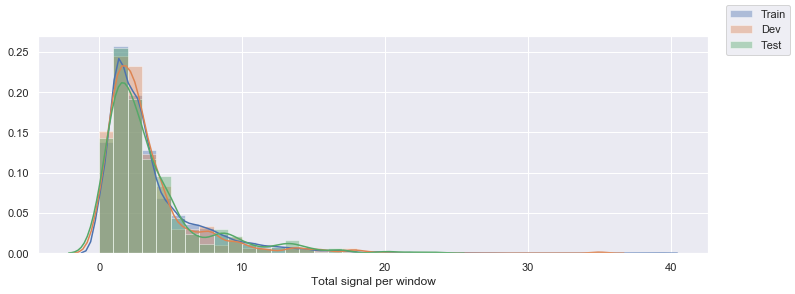

In [96]:
"""Sanity check that the normalization really worked"""

from ae.utils import plot_total_signal

plot_total_signal('ENCSR320PGJ', base=base)

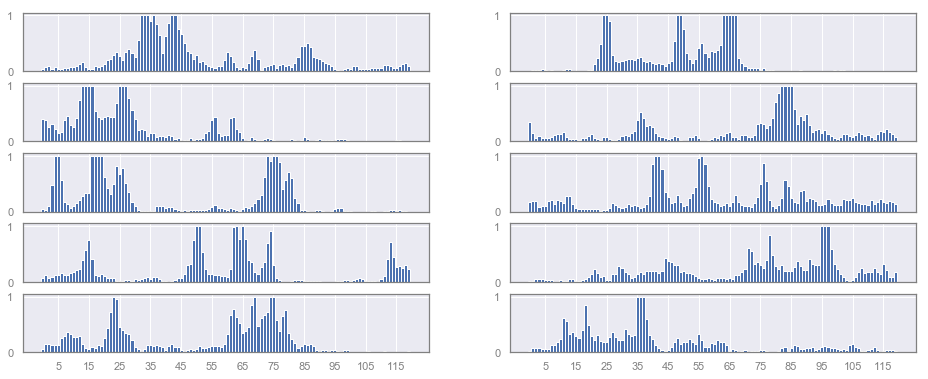

In [133]:
from ae.utils import plot_windows

plot_windows('ENCSR320PGJ', min_signal=20, base=base)

In [25]:
"""Merge data"""

from merge import merge

merge(
    datasets,
    settings,
    base=base,
    clear=False,
    verbose=False,
    dtype='float32'
)

### 4. Create jobs for training various CAE models

In [37]:
from jobs import jobs

jobs(
    os.path.relpath(cnn_optimization_filepath, base),
    os.path.relpath(settings_filepath, base),
    dataset='merged',
    name='cnn-optimization',
    epochs=25,
    batch_size=256,
    base=base,
    clear=True,
    verbose=False
)


Created slurm file for training 144 neural networks


### 5. Test CAEs training

In [6]:
from train import train

model_name = 'cf-32-64-128--ck-3-5-7--du-1024-512-256-64-32--do-0.1-0.1-0.1-0.1-0.1-0.1-0.1-0.1--e-10--rl-0--o-adam--lr-0.01--lrd-0.0--l-smse-2--m-'

# Load the CAE definition, training settings, datasets, and define training parameters
with open('../models/{}.json'.format(model_name), 'r') as f:
    definition = json.load(f)

# Start the training
train(
    settings,
    dataset_ids,
    definition,
    epochs=2,
    batch_size=1024,
    peak_weight=2,
    signal_weighting='logn',
    signal_weighting_zero_point_percentage=0.02,
    base=base,
    clear=True
)

KeyboardInterrupt: 

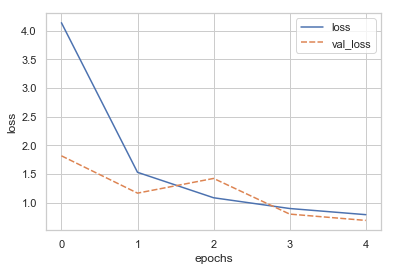

In [206]:
from train import train_on_single_dataset

model_name = 'cf-32-64-128--ck-3-5-7--du-512-256-128--do-0-0-0-0-0-0--e-10--rl-0--o-adam--lr-0.001--lrd-0.0--l-smse-10--m-'
model_name = 'cf-32-64-128--ck-7-5-3--du---do-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.0--l-smse-10--m-'

# Load the CAE definition, training settings, datasets, and define training parameters
with open('../models/{}.json'.format(model_name), 'r') as f:
    definition = json.load(f)

# Start the training
train_on_single_dataset(
    settings,
    'merged',
    definition,
    epochs=5,
    batch_size=128,
    peak_weight=2,
    signal_weighting='logn',
    signal_weighting_zero_point_percentage=0.02,
    base=base,
    clear=True,
    train_on_hdf5=False,
    train_on_cnn2=False,
)

Train: cf-32-64-128--ck-7-5-3--du---do-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-



Train: cf-32-64-128--ck-3-5-7--du---do-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-


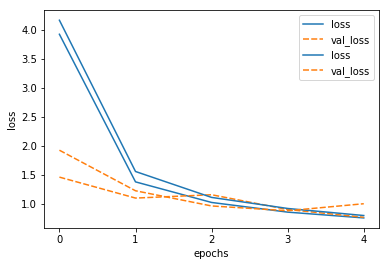

In [26]:
from train import train_on_single_dataset

model_names = [
    'cf-32-64-128--ck-7-5-3--du---do-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-',
    'cf-32-64-128--ck-3-5-7--du---do-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-',
]
    
for model_name in model_names:
    print('Train: {}'.format(model_name))
    
    # Load the CAE definition, training settings, datasets, and define training parameters
    with open('../models/{}.json'.format(model_name), 'r') as f:
        definition = json.load(f)

    # Start the training
    train_on_single_dataset(
        settings,
        'merged',
        definition,
        epochs=5,
        batch_size=128,
        peak_weight=2,
        signal_weighting='logn',
        signal_weighting_zero_point_percentage=0.02,
        base=base,
        clear=True,
        train_on_hdf5=False,
    )

Evaluate: cf-32-64-128--ck-7-5-3--du---do-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-
Evaluate: cf-32-64-128--ck-3-5-7--du---do-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-


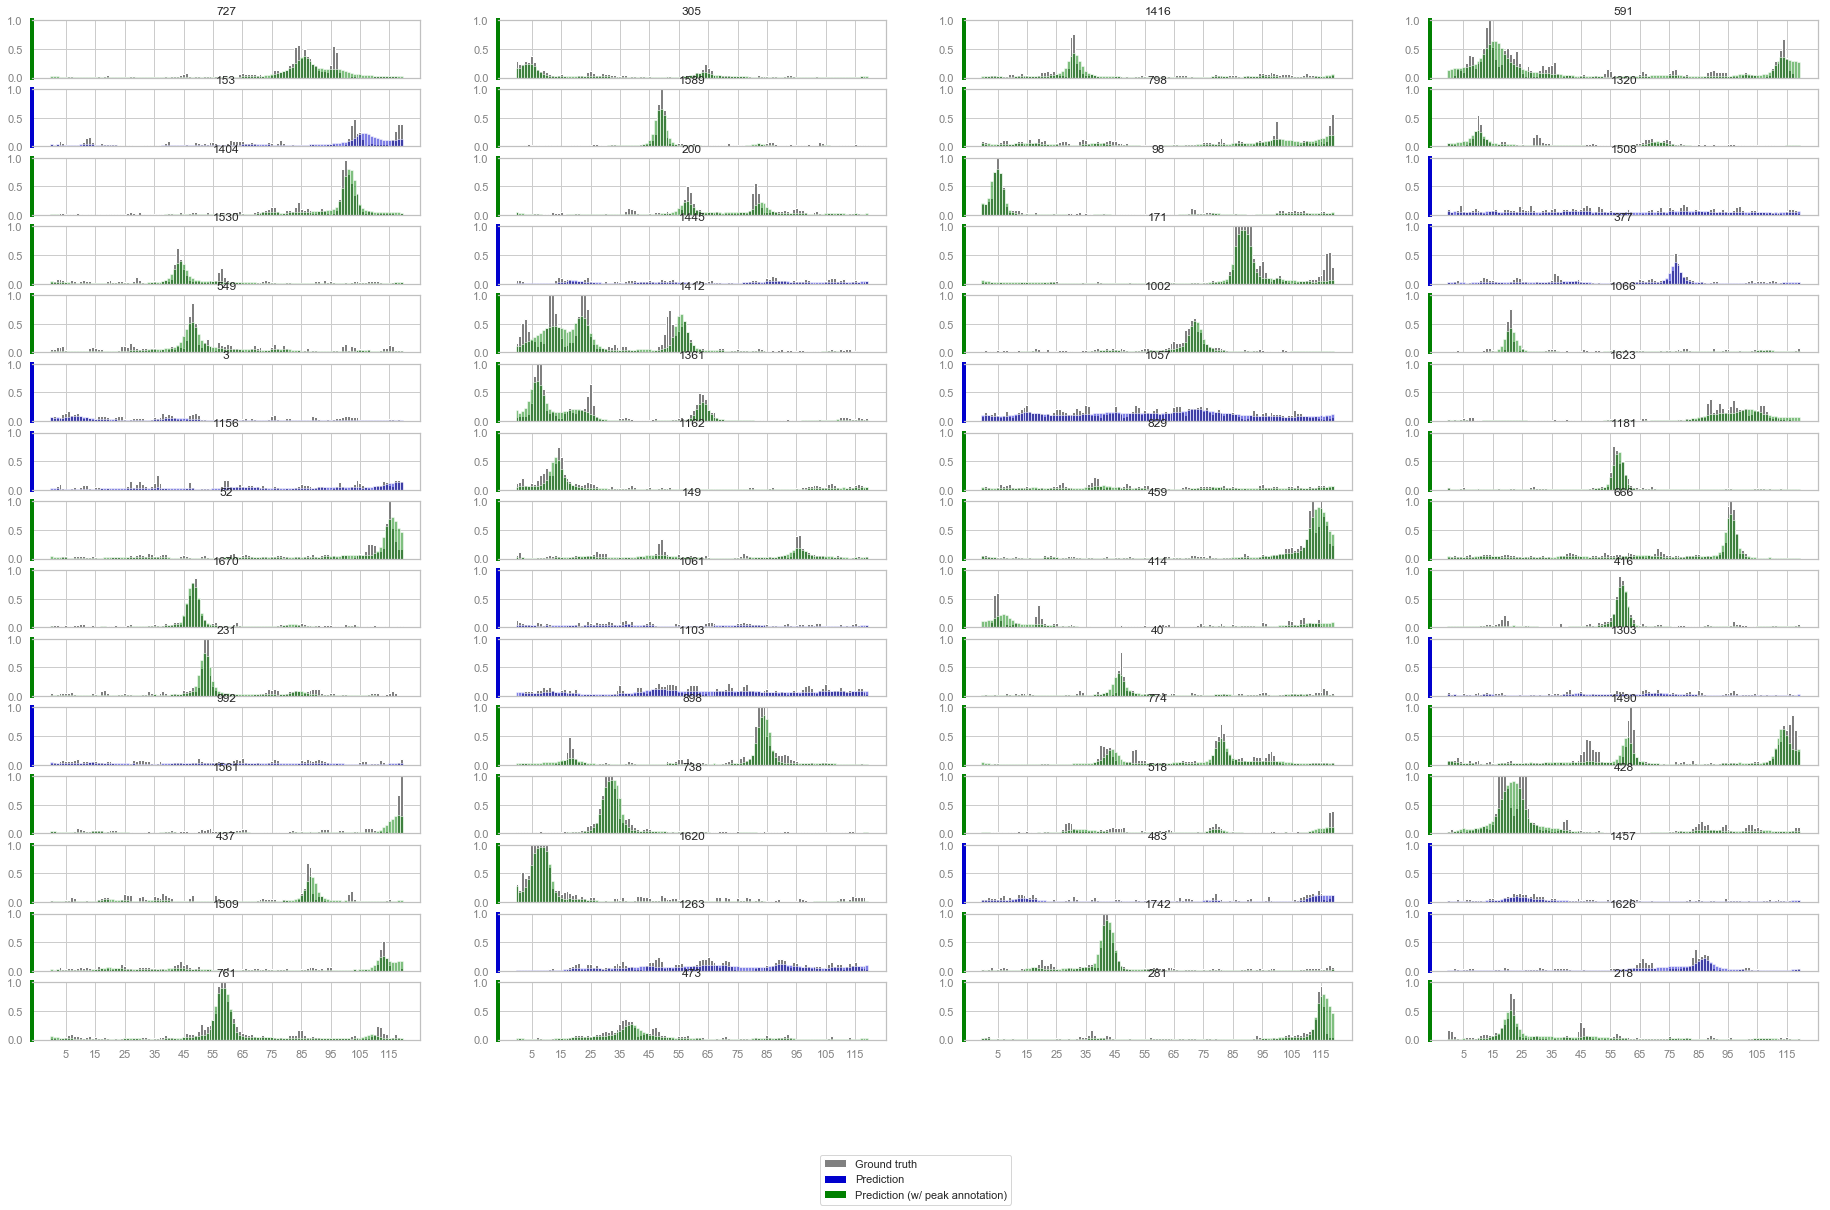

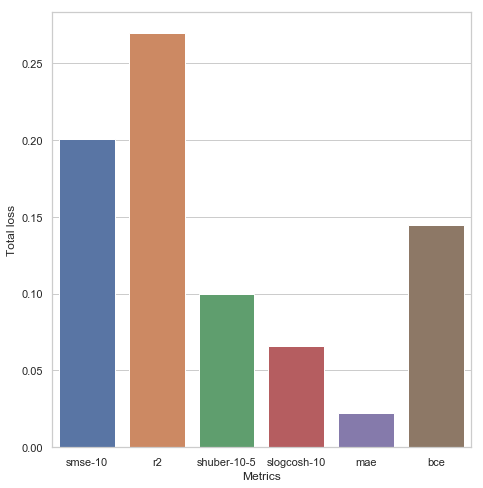

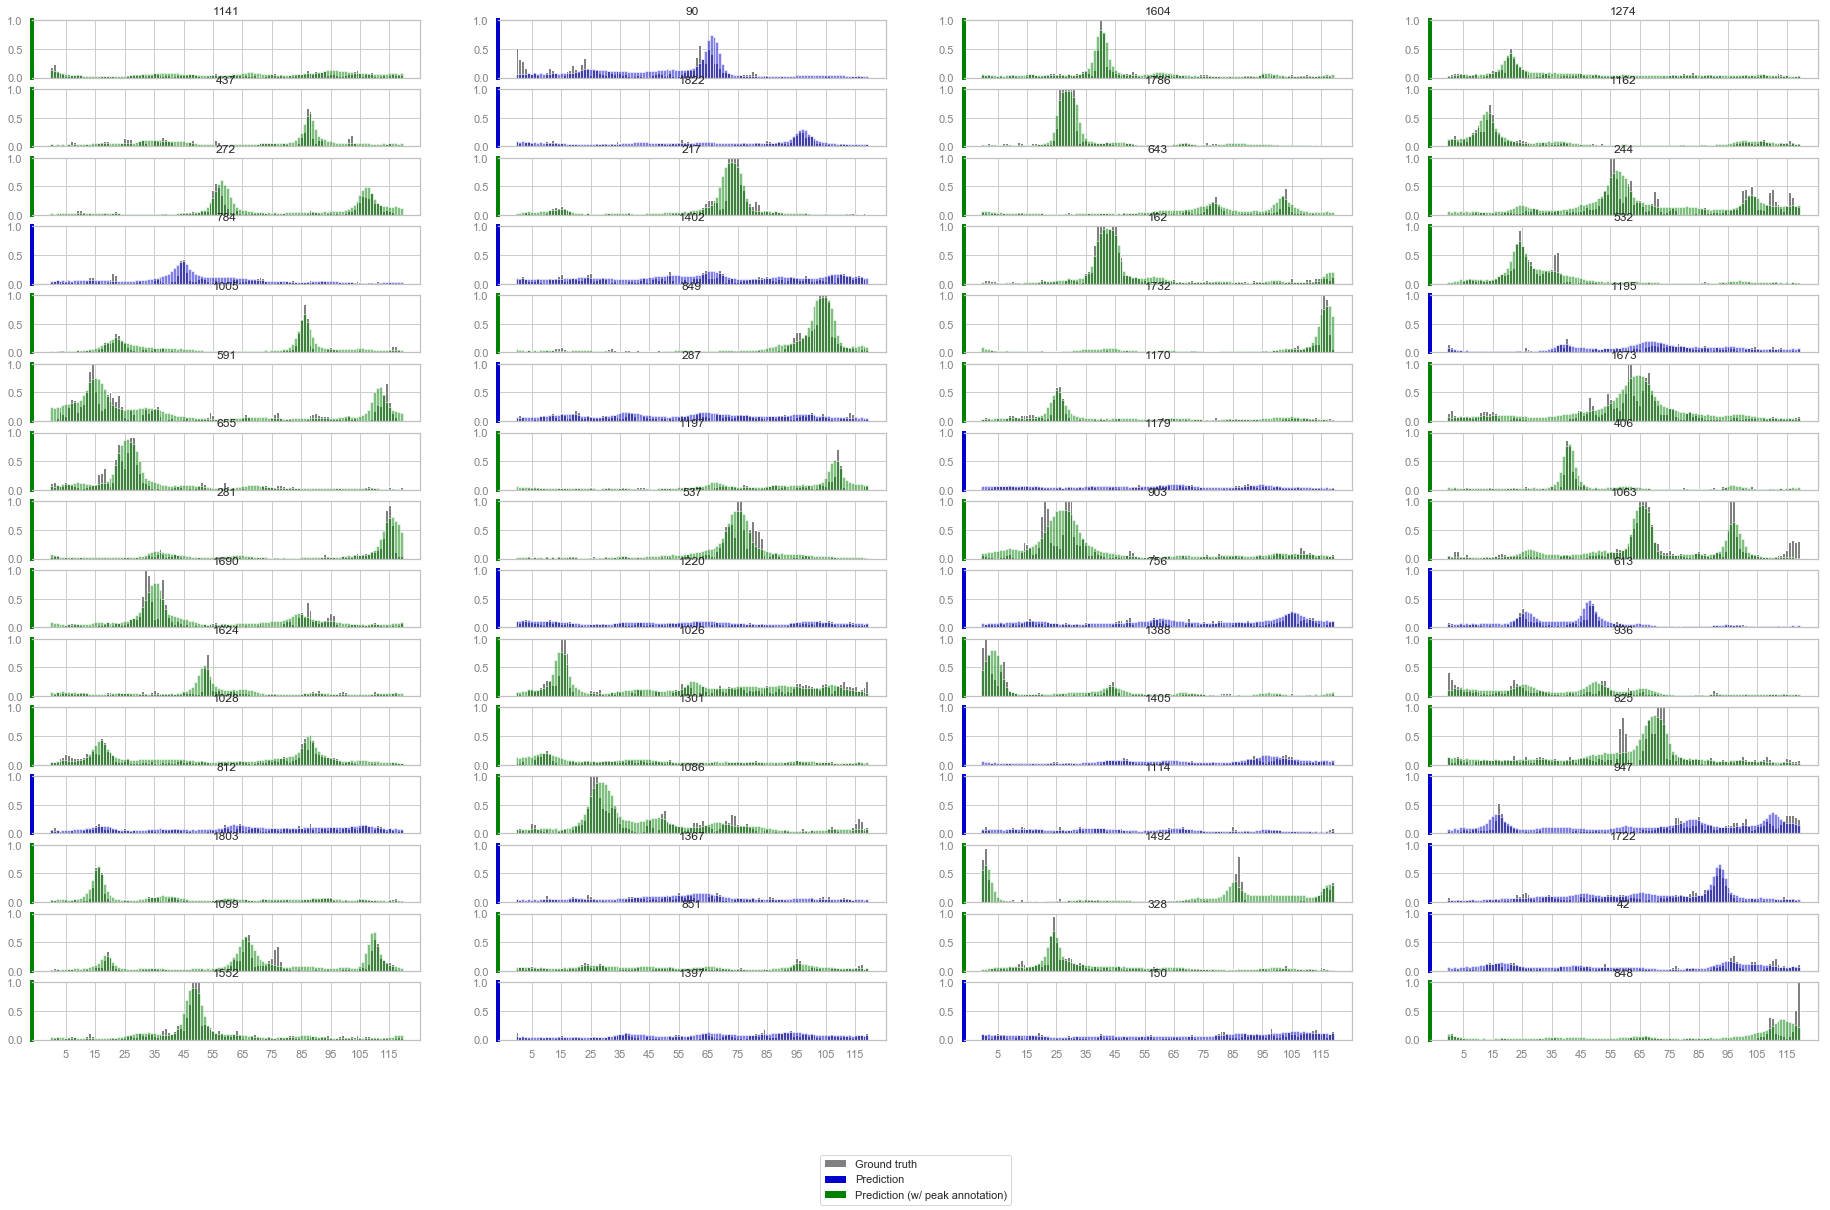

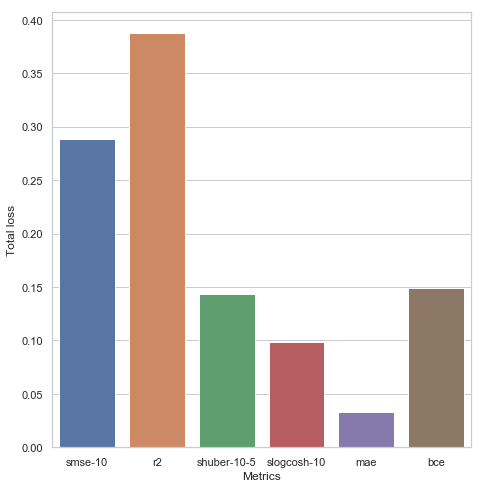

In [34]:
from evaluate import evaluate
    
for model_name in model_names:
    print('Evaluate: {}'.format(model_name))

    evaluate(
        model_name,
        dataset_name='merged',
        base=base,
        clear=True,
        silent=True
    )

,smse-10,r2,shuber-10-5,slogcosh-10,mae,bce,t mean,t median,t min,t max
7-5-3--du---do-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-,0.200452,0.269591,0.099601,0.066106,0.022525,0.144663,10.040911,9.854801,9.846328,10.746603
3-5-7--du---do-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-,0.288139,0.387524,0.143579,0.098838,0.032654,0.149507,7.616051,7.366007,7.261882,8.541300


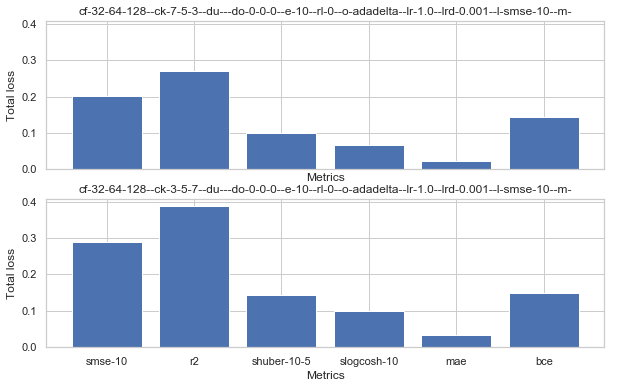

In [31]:
import json
import os

from compare import compare

# Store model_names
with open(os.path.join(base, "tmp-can-be-removed.json"), "w") as f:
    json.dump(model_names, f)

compare(
    "tmp-can-be-removed.json",
    dataset_name="merged",
    remove_common_prefix_from_df=True,
    base=base,
    clear=False,
)

#### Visualize training and validation loss

### 6. Evaluate CAEs

In [31]:
from evaluate import evaluate

evaluate(
    'cf-32-64-128--ck-3-5-7--du-512-256-128--do-0-0-0-0-0-0--e-10--rl-0--o-adam--lr-0.01--lrd-0.0--l-smse-2--m-',
    datasets,
    base=base,
    clear=True
)